In [1]:
# Cell 1: Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import os

# Paths
PROJECT_ROOT = Path(r"D:\Portfolio Optimzation project")
RESULTS_DIR = PROJECT_ROOT / "results" / "diagnostics"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Files
IC_FILE = RESULTS_DIR / "ic_timeseries.csv"
DISP_FILE = RESULTS_DIR / "alpha_dispersion.csv"


In [2]:
# Cell 2: Load and merge diagnostics

ic_df = pd.read_csv(IC_FILE, parse_dates=["date"])
disp_df = pd.read_csv(DISP_FILE, parse_dates=["date"])

# Merge on date
merged_df = pd.merge(ic_df, disp_df, on="date", how="inner", suffixes=("_ic", "_disp"))
merged_df = merged_df.sort_values("date").reset_index(drop=True)

print(f"Merged diagnostics: {merged_df.shape[0]} monthly records.")
display(merged_df.head())


Merged diagnostics: 85 monthly records.


,date,IC,n,rolling_mean_ic,rolling_std,mean,dispersion,min,max,rolling_disp,rolling_mean_disp
0,2016-08-31,-0.021865,346,NaN,NaN,0.020600,0.002468,0.010342,0.031397,NaN,NaN
1,2016-09-30,-0.039941,347,NaN,NaN,0.021037,0.001581,0.013869,0.029447,NaN,NaN
2,2016-10-30,-0.145097,348,NaN,NaN,0.015256,0.002035,0.012401,0.025920,NaN,NaN
3,2016-11-30,-0.175700,351,NaN,NaN,0.016011,0.005120,0.005581,0.033760,NaN,NaN
4,2016-12-30,0.180776,353,NaN,NaN,0.015334,0.004510,0.008582,0.046263,NaN,NaN


Correlation between IC and alpha dispersion: -0.003


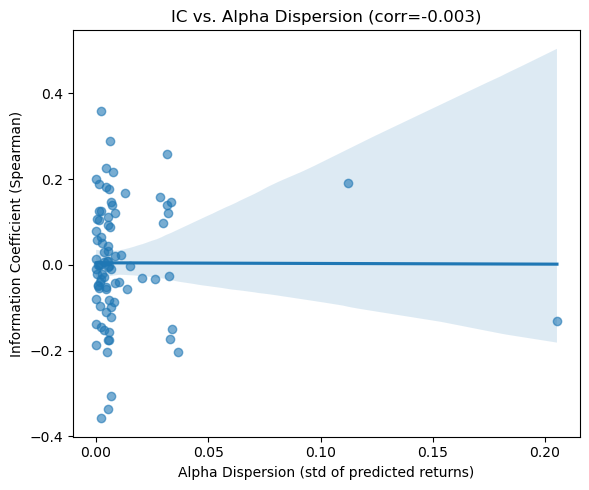

In [3]:
# Cell 3: Compute correlation between IC and dispersion

corr_value = merged_df["IC"].corr(merged_df["dispersion"])
print(f"Correlation between IC and alpha dispersion: {corr_value:.3f}")

# Scatter plot
plt.figure(figsize=(6,5))
sns.regplot(data=merged_df, x="dispersion", y="IC", scatter_kws={"alpha":0.6})
plt.title(f"IC vs. Alpha Dispersion (corr={corr_value:.3f})")
plt.xlabel("Alpha Dispersion (std of predicted returns)")
plt.ylabel("Information Coefficient (Spearman)")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "ic_vs_dispersion.png", dpi=200)
plt.show()


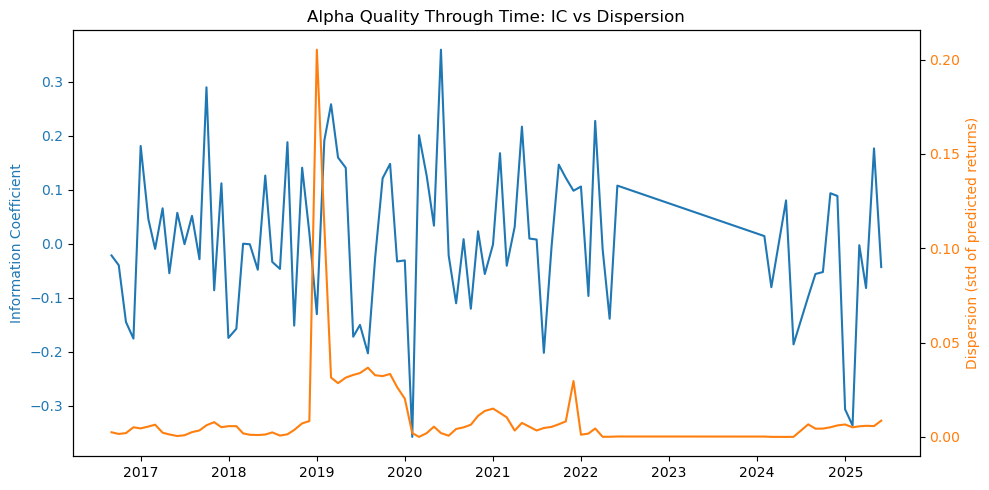

In [4]:
# Cell 4: Plot IC and Dispersion Over Time

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(merged_df["date"], merged_df["IC"], label="Information Coefficient (IC)", color="tab:blue", linewidth=1.5)
ax1.set_ylabel("Information Coefficient", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# Secondary axis for dispersion
ax2 = ax1.twinx()
ax2.plot(merged_df["date"], merged_df["dispersion"], label="Alpha Dispersion", color="tab:orange", linewidth=1.5)
ax2.set_ylabel("Dispersion (std of predicted returns)", color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")

plt.title("Alpha Quality Through Time: IC vs Dispersion")
fig.tight_layout()
plt.savefig(RESULTS_DIR / "ic_dispersion_timeseries.png", dpi=200)
plt.show()


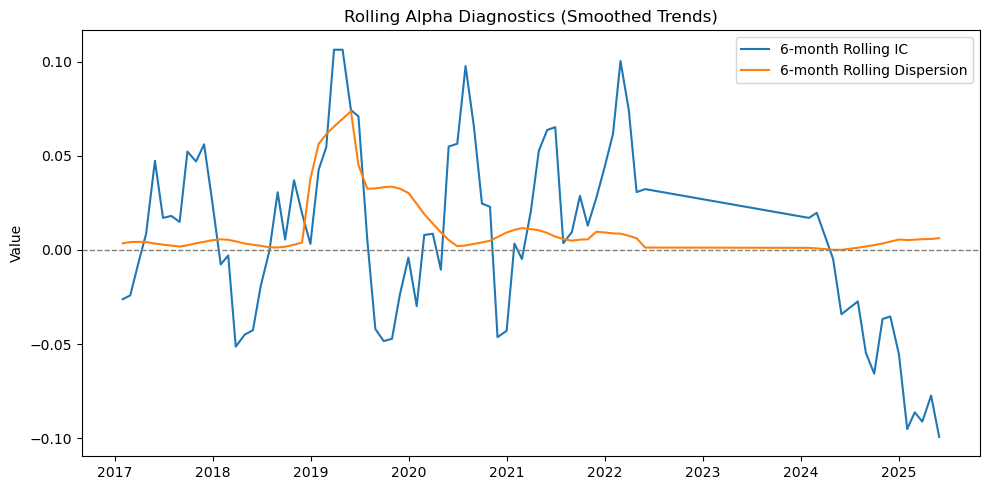

In [5]:
# Cell 5: Rolling dashboard (smooth trends)

ROLL_WINDOW = 6
merged_df["IC_roll"] = merged_df["IC"].rolling(ROLL_WINDOW).mean()
merged_df["Disp_roll"] = merged_df["dispersion"].rolling(ROLL_WINDOW).mean()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(merged_df["date"], merged_df["IC_roll"], label=f"{ROLL_WINDOW}-month Rolling IC", color="tab:blue")
ax.plot(merged_df["date"], merged_df["Disp_roll"], label=f"{ROLL_WINDOW}-month Rolling Dispersion", color="tab:orange")
ax.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.legend()
ax.set_title("Rolling Alpha Diagnostics (Smoothed Trends)")
ax.set_ylabel("Value")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "rolling_alpha_dashboard.png", dpi=200)
plt.show()


In [6]:
# Cell 6: Summary and Insights

avg_ic = merged_df["IC"].mean()
std_ic = merged_df["IC"].std()
pos_ic = (merged_df["IC"] > 0).mean() * 100

avg_disp = merged_df["dispersion"].mean()
corr_ic_disp = merged_df["IC"].corr(merged_df["dispersion"])

print("=== ALPHA DIAGNOSTICS SUMMARY ===")
print(f"Mean Information Coefficient (IC): {avg_ic:.4f}")
print(f"IC Std Dev: {std_ic:.4f}")
print(f"Positive IC %: {pos_ic:.1f}%")
print(f"Average Dispersion: {avg_disp:.4f}")
print(f"IC–Dispersion Correlation: {corr_ic_disp:.3f}")

# Simple interpretation
if avg_ic > 0.05:
    ic_msg = "🔥 Strong predictive alpha — model forecasts future returns well."
elif avg_ic > 0.02:
    ic_msg = "✅ Moderate predictive alpha — signals have real value."
elif avg_ic > 0:
    ic_msg = "⚠️ Weak but positive alpha — needs feature tuning or better targets."
else:
    ic_msg = "❌ No predictive alpha — model signals are random."

if avg_disp > 0.05:
    disp_msg = "🔥 Strong cross-sectional variation — model distinguishes stocks well."
elif avg_disp > 0.02:
    disp_msg = "✅ Reasonable differentiation — optimizer can work effectively."
else:
    disp_msg = "⚠️ Weak dispersion — predictions nearly flat; optimization limited."

print("\n--- INTERPRETATION ---")
print(ic_msg)
print(disp_msg)
if corr_ic_disp > 0.2:
    print("📈 Higher dispersion tends to coincide with better predictive IC (healthy signal).")
else:
    print("📉 Dispersion doesn’t align with IC — model may not generalize well.")


=== ALPHA DIAGNOSTICS SUMMARY ===
Mean Information Coefficient (IC): 0.0047
IC Std Dev: 0.1379
Positive IC %: 45.9%
Average Dispersion: 0.0117
IC–Dispersion Correlation: -0.003

--- INTERPRETATION ---
⚠️ Weak but positive alpha — needs feature tuning or better targets.
⚠️ Weak dispersion — predictions nearly flat; optimization limited.
📉 Dispersion doesn’t align with IC — model may not generalize well.


Result Breakdown

| Metric                 | Value  | Interpretation                                                                               |
| ---------------------- | ------ | -------------------------------------------------------------------------------------------- |
| **Mean IC**            | 0.0047 | Almost zero correlation between predicted & realized returns → alphas are weakly predictive. |
| **IC Std Dev**         | 0.1379 | Moderate variability — some months the alpha worked, some months failed.                     |
| **Positive IC %**      | 45.9%  | Only half the time your model ranked stocks correctly (should be >55% ideally).              |
| **Average Dispersion** | 0.0117 | Very small spread — all predictions are close to each other (flat signal).                   |
| **IC–Dispersion Corr** | -0.003 | No relationship between prediction confidence and actual success.                            |


Diagnosing the Weakness

| Area                            | Problem                                                            | Evidence            | Fix                                                                   |
| ------------------------------- | ------------------------------------------------------------------ | ------------------- | --------------------------------------------------------------------- |
| **Feature engineering**         | Predictors may not capture momentum, volatility, or factor effects | IC ≈ 0              | Add more predictive factors                                           |
| **Alpha dispersion**            | All predictions too similar                                        | Dispersion = 0.0117 | Scale/normalize features differently, avoid model over-regularization |
| **Target design**               | If target = next-day returns, too noisy                            | High IC std         | Use 5-day or 21-day horizon targets                                   |
| **Model regularization**        | LASSO too restrictive                                              | Flat weights        | Try Ridge or ElasticNet for smoother coefficients                     |
| **Cross-sectional sample size** | Few tickers or narrow date range                                   | Weak IC pattern     | Expand training period or ticker universe                             |
